# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.metrics import f1_score , precision_score , recall_score , roc_auc_score , accuracy_score , roc_curve, confusion_matrix , classification_report

from tensorflow.keras.models import Sequential , clone_model , load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.activations import sigmoid

from imblearn.over_sampling import ADASYN
from collections import Counter

import warnings
warnings.filterwarnings(action="ignore")
plt.rcParams["figure.figsize"] = (12,8)
pd.set_option("display.max_columns" , None)

# Variables' Description
* **Date** - The date of observation
* **Location** - The common name of the location of the weather station
* **MinTemp** - The minimum temperature in degrees celsius
* **MaxTemp** - The maximum temperature in degrees celsius
* **Rainfall** - The amount of rainfall recorded for the day in mm
* **Evaporation** - The so-called Class A pan evaporation (mm) in the 24 hours to 9am
* **Sunshine** - The number of hours of bright sunshine in the day.
* **WindGustDir** - The direction of the strongest wind gust in the 24 hours to midnight
* **WindGustSpeed** - The speed (km/h) of the strongest wind gust in the 24 hours to midnight
* **WindDir9am** - Direction of the wind at 9am
* **WindDir3pm** - Direction of the wind at 3pm
* **WindSpeed9am** - Wind speed (km/hr) averaged over 10 minutes prior to 9am
* **WindSpeed3pm** - Wind speed (km/hr) averaged over 10 minutes prior to 3pm
* **Humidity9am** - Humidity (percent) at 9am
* **Humidity3pm** - Humidity (percent) at 3pm
* **Pressure9am** - Atmospheric pressure (hpa) reduced to mean sea level at 9am
* **Pressure3pm** - Atmospheric pressure (hpa) reduced to mean sea level at 3pm
* **Cloud9am** - Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
* **Cloud3pm** - Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values
* **Temp9am** - Temperature (degrees C) at 9am
* **Temp3pm** - Temperature (degrees C) at 3pm
* **RainToday** - Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
* **RainTomorrow** - The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk".

# Importing Dataset

In [2]:
data = pd.read_csv("weatherAUS.csv")
df = data.copy()
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Checking the number of the null values for each column

In [3]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

# If there are null values more than 30 % for each column it will be droped

In [4]:
df.dropna(axis =1 , thresh=df.shape[0] * 0.70 , inplace = True)

In [5]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

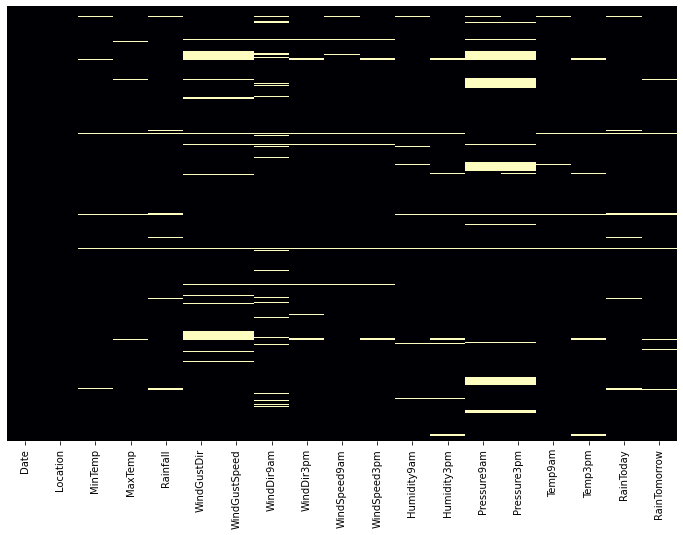

In [6]:
sns.heatmap(data = df.isnull(), cmap = "magma" , cbar=False , yticklabels=False , xticklabels=True)
plt.show()

In [7]:
# Handling Missing Values
imputer_int = SimpleImputer(missing_values=np.nan , strategy="median")
imputer_str = SimpleImputer(missing_values=np.nan , strategy="most_frequent")

# Replacing NA in numerical variable with the median of the variable and replacing NA in categorical vairables with the the mode of the variable

In [8]:
for x in df.select_dtypes(include="number") :
    for i in df.select_dtypes(exclude="number") : 
        df[x] = imputer_int.fit_transform(df[[x]]).ravel()
        df[i] = imputer_str.fit_transform(df[[i]]).ravel()

In [9]:
df.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

# Checking if there are duplicates in the dataset or not

In [10]:
print("There are {} duplicates in the dataset".format(df.duplicated().sum()))

There are 0 duplicates in the dataset


# Spliting Date column to 3 new columns

In [11]:
main_dataframe = df["Date"].str.split("-" , expand  = True)
main_dataframe.columns = ["Year" , "Month" , "Day"]
main_dataframe

,Year,Month,Day
0,2008,12,01
1,2008,12,02
2,2008,12,03
3,2008,12,04
4,2008,12,05
...,...,...,...
145455,2017,06,21
145456,2017,06,22
145457,2017,06,23
145458,2017,06,24


# Combining new variables with the main data

In [12]:
df.drop(columns = ["Date" , "Location"] , inplace = True)
df = pd.concat([df , main_dataframe] , axis = 1)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,2008,12,01
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,2008,12,02
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,2008,12,03
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,2008,12,04
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,2008,12,05


In [13]:
df["WindDir3pm"].value_counts(normalize = True)

SE     0.103575
W      0.069504
S      0.068239
WSW    0.065434
SSE    0.064616
SW     0.064306
N      0.061116
WNW    0.061006
NW     0.059192
ESE    0.058470
E      0.058243
NE     0.056806
SSW    0.056070
NNW    0.054104
ENE    0.054015
NNE    0.045305
Name: WindDir3pm, dtype: float64

# Replacing wind's tpyes with "Other" word except West , East , North and South

In [14]:
for x in ["WindGustDir" , "WindDir9am" , "WindDir3pm"] : 
    df.loc[(df[x] != "W")&(df[x] != "S")&(df[x] != "N")&(df[x] != "E") , x] = "Other"

In [15]:
df["WindDir3pm"].unique()

array(['Other', 'E', 'W', 'N', 'S'], dtype=object)

In [16]:
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,13.4,22.9,0.6,W,44.0,W,Other,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No,2008,12,01
1,7.4,25.1,0.0,Other,44.0,Other,Other,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No,2008,12,02
2,12.9,25.7,0.0,Other,46.0,W,Other,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No,2008,12,03
3,9.2,28.0,0.0,Other,24.0,Other,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No,2008,12,04
4,17.5,32.3,1.0,W,41.0,Other,Other,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No,2008,12,05


# Encoding variables with map function.

In [17]:
df["RainToday"] = df["RainToday"].map({"No" : 0 , "Yes" : 1})
df["RainTomorrow"] = df["RainTomorrow"].map({"No" : 0 , "Yes" : 1})

In [18]:
for x in ["WindGustDir" , "WindDir9am" , "WindDir3pm"] : 
    df[x] = df[x].map({"N" : 0 , "S" : 1 , "E" : 2 , "W" : 3 , "Other" : 4})

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   MinTemp        145460 non-null  float64
 1   MaxTemp        145460 non-null  float64
 2   Rainfall       145460 non-null  float64
 3   WindGustDir    145460 non-null  int64  
 4   WindGustSpeed  145460 non-null  float64
 5   WindDir9am     145460 non-null  int64  
 6   WindDir3pm     145460 non-null  int64  
 7   WindSpeed9am   145460 non-null  float64
 8   WindSpeed3pm   145460 non-null  float64
 9   Humidity9am    145460 non-null  float64
 10  Humidity3pm    145460 non-null  float64
 11  Pressure9am    145460 non-null  float64
 12  Pressure3pm    145460 non-null  float64
 13  Temp9am        145460 non-null  float64
 14  Temp3pm        145460 non-null  float64
 15  RainToday      145460 non-null  int64  
 16  RainTomorrow   145460 non-null  int64  
 17  Year           145460 non-nul

# Changing object dtypes to numeric

In [20]:
for x in ["Year" , "Month" , "Day"] : 
    df[x] = pd.to_numeric(df[x])

# Spliting dataset to X and y

In [21]:
X = df.drop(columns = "RainTomorrow")
y = df["RainTomorrow"]

# Pie chart for checking if the data is balanced or not

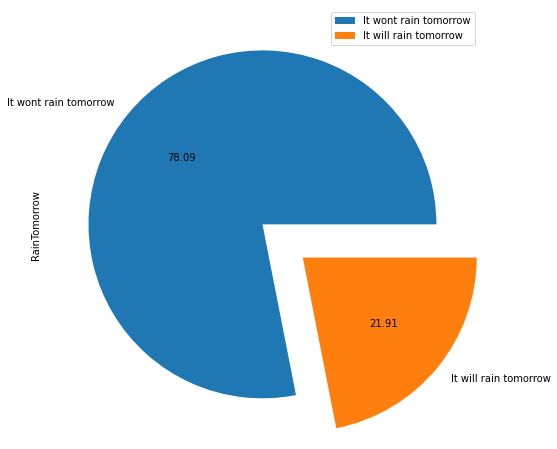

In [22]:
y.value_counts().plot(kind = "pie" , autopct = "%.2f" , explode = [0.0 , 0.3] , labels = ["It wont rain tomorrow" , "It will rain tomorrow"])
plt.legend()
plt.show()

# Data is inbalanced so I will apply Over Sampling method

In [23]:
over_sampling = ADASYN(sampling_strategy=0.95 , random_state=42)
X_res , y_res = over_sampling.fit_resample(X , y)

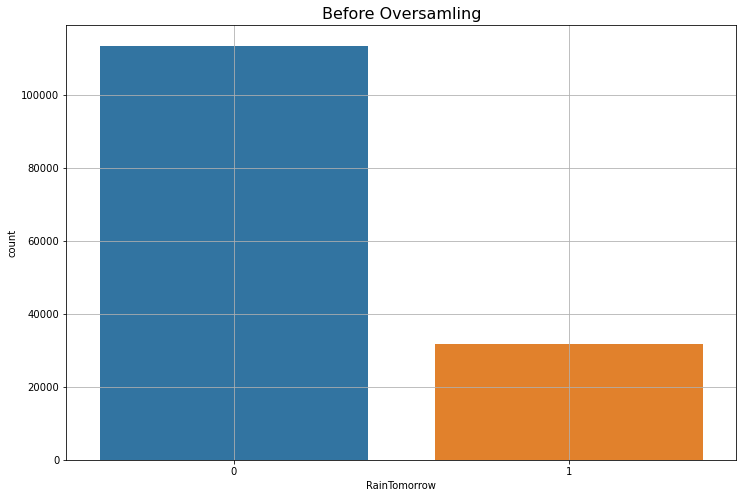

In [24]:
sns.countplot(data = pd.DataFrame(y) , x = y)
plt.title("Before Oversamling" , fontsize= 16)
plt.grid()
plt.show()

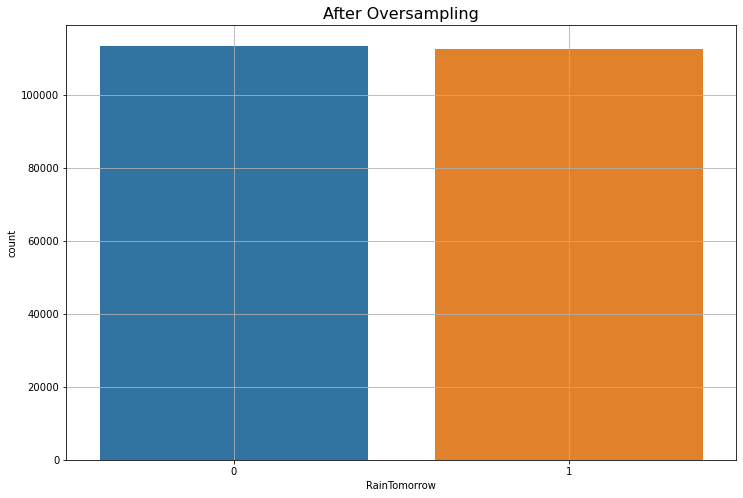

In [25]:
sns.countplot(data = pd.DataFrame(y_res) , x = y_res)
plt.title("After Oversampling" , fontsize = 16)
plt.grid()
plt.show()

In [26]:
X , y = X_res , y_res

# Spliting to train and test dataset

In [27]:
X_train , X_test_data , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

# Applying Standart scaler for to normalize X_train and X_test in a particular range

In [28]:
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test_data)

# Converting train and test dataset to tensors

In [29]:
X_train_tf = tf.data.Dataset.from_tensor_slices(tensors = X_train)
y_train_tf = tf.data.Dataset.from_tensor_slices(tensors = y_train)

X_test_tf = tf.data.Dataset.from_tensor_slices(tensors = X_test)
y_test_tf = tf.data.Dataset.from_tensor_slices(tensors = y_test)

# Combining train and test tensors with zip function

In [30]:
train_zip = tf.data.Dataset.zip(datasets=(X_train_tf , y_train_tf))
test_zip = tf.data.Dataset.zip(datasets=(X_test_tf , y_test_tf))

# Defining the batch sizes, creating train_set and test_set

In [31]:
train_set = train_zip.batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_zip.batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating the callbacks inside the function

In [32]:
def callbacks_function(model_path , verbosity) : 
    early = EarlyStopping(monitor="val_loss" , patience=20 , verbose=verbosity , restore_best_weights=True)
    check = ModelCheckpoint(filepath=model_path , monitor="val_loss" , verbose = verbosity , save_best_only=True)
    
    calbacks = [early , check]
    
    return calbacks

# Modeling

In [33]:
tf.random.set_seed(42)

model = Sequential(layers = [
    Dense(units = 128 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 128 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 256 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 256 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units = 256 , activation="relu"),
    Dropout(rate = 0.2 , seed = 42),
    Dense(units=1 , activation="sigmoid")
] , name = "Neural_Network")

model.compile(optimizer=Adam() , loss=BinaryCrossentropy() , metrics=["accuracy"])

model_traning = model.fit(train_set , validation_data = test_set , epochs = 500 , callbacks = callbacks_function(model_path=f"{model.name}.h5" , verbosity=1) , verbose = 1)

Epoch 1/500
2824/2828 [============================>.] - ETA: 0s - loss: 0.5240 - accuracy: 0.7409
Epoch 1: val_loss improved from inf to 0.50371, saving model to Neural_Network.h5
2828/2828 [==============================] - 12s 4ms/step - loss: 0.5239 - accuracy: 0.7409 - val_loss: 0.5037 - val_accuracy: 0.7648
Epoch 2/500
2826/2828 [============================>.] - ETA: 0s - loss: 0.4901 - accuracy: 0.7644
Epoch 2: val_loss improved from 0.50371 to 0.48057, saving model to Neural_Network.h5
2828/2828 [==============================] - 11s 4ms/step - loss: 0.4901 - accuracy: 0.7644 - val_loss: 0.4806 - val_accuracy: 0.7719
Epoch 3/500
2818/2828 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.7710
Epoch 3: val_loss improved from 0.48057 to 0.47202, saving model to Neural_Network.h5
2828/2828 [==============================] - 10s 4ms/step - loss: 0.4776 - accuracy: 0.7710 - val_loss: 0.4720 - val_accuracy: 0.7769
Epoch 4/500
2822/2828 [========================

# Classification Report

In [34]:
y_pred = tf.math.round(tf.squeeze(model.predict(test_set))).numpy()
print(classification_report(y_test , y_pred))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80     22684
           1       0.77      0.90      0.83     22562

    accuracy                           0.81     45246
   macro avg       0.82      0.81      0.81     45246
weighted avg       0.82      0.81      0.81     45246



# The performance of the model for per epoch.

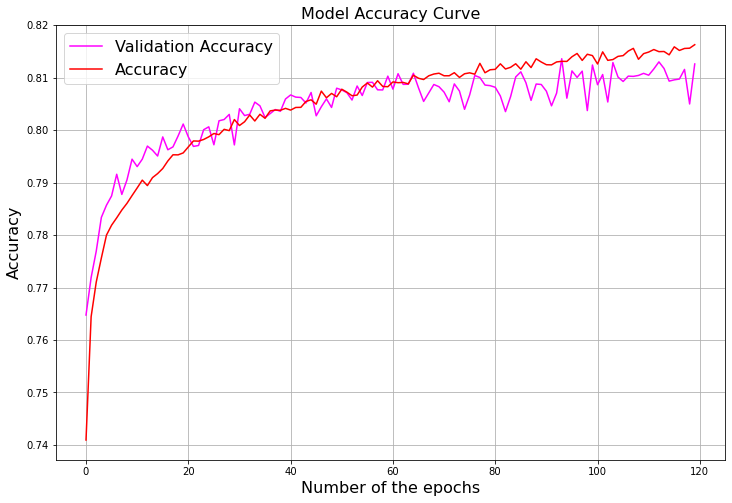

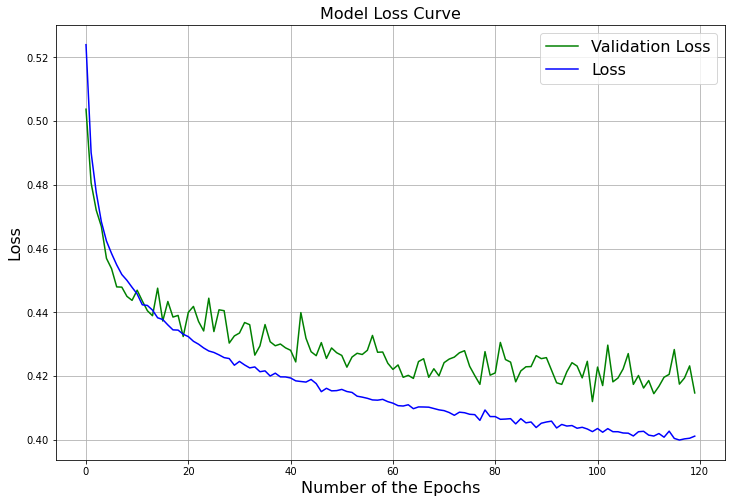

In [35]:
valid_accuracy = model_traning.history["val_accuracy"]
accuracy = model_traning.history["accuracy"]

plt.plot(valid_accuracy , label = "Validation Accuracy" , c = "magenta")
plt.plot(accuracy , label = "Accuracy" , c = "red")
plt.title("Model Accuracy Curve" , fontsize = 16)
plt.ylabel("Accuracy" , fontsize = 16)
plt.xlabel("Number of the epochs" , fontsize = 16)
plt.grid()
plt.legend(loc = "best" , fontsize = 16)
plt.show()

print()

valid_loss = model_traning.history["val_loss"]
loss = model_traning.history["loss"]

plt.plot(valid_loss , label = "Validation Loss" , c = "green")
plt.plot(loss , label = "Loss" , c = "blue")
plt.title("Model Loss Curve" , fontsize = 16)
plt.ylabel("Loss" , fontsize = 16)
plt.xlabel("Number of the Epochs" , fontsize = 16)
plt.grid()
plt.legend(loc = "best" , fontsize = 16)
plt.show()

# Metrics

In [36]:
prediction = tf.math.round(tf.squeeze(model.predict(test_set)).numpy())

_ , train_score = model.evaluate(train_set , verbose=0)
_ , test_score = model.evaluate(test_set , verbose = 0)

precision = precision_score(y_test , prediction)
recall = recall_score(y_test , prediction)
precision = precision_score(y_test , prediction)
recall = recall_score(y_test , prediction)
roc = roc_auc_score(y_test , prediction)
gini = (2*roc) - 1
f1 = f1_score(y_test , prediction)
acuracy = accuracy_score(y_test , y_pred)

print("The train score is {:.2%}".format(train_score))
print("The test score is {:.2%}".format(test_score))
print("The precssion score is {:.2%}".format(precision))
print("The recall score is {:.2%}".format(recall))
print("The roc score is {:.2%}".format(roc))
print("The gini score is {:.2%}".format(gini))
print("The f1 score is {:.2%}".format(f1))
print("The accuracy score is {:.2%}".format(acuracy))

The train score is 83.48%
The test score is 81.24%
The precssion score is 76.74%
The recall score is 89.52%
The roc score is 81.26%
The gini score is 62.53%
The f1 score is 82.64%
The accuracy score is 81.24%


# Confussion Matrix with Ratio 

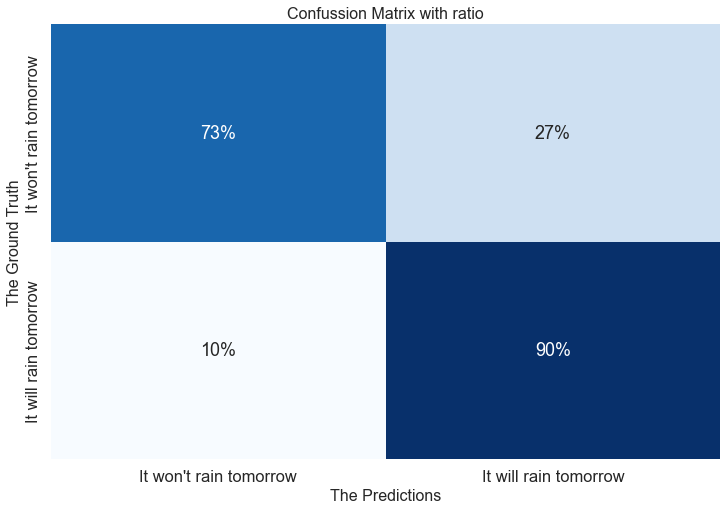

In [37]:
sns.set(font_scale = 1.5 , palette = "bright")
y_pred = tf.math.round(tf.squeeze(model.predict(test_set))).numpy()
cm = confusion_matrix(y_test , y_pred)
upper_row = cm[0]/np.sum(cm , axis = 1)[0]
lower_row = cm[1]/np.sum(cm, axis = 1)[1]
result = np.vstack([upper_row , lower_row])

sns.heatmap(data = result , cmap = plt.cm.Blues , cbar = False , yticklabels=["It won't rain tomorrow" , "It will rain tomorrow"], 
            xticklabels=["It won't rain tomorrow" , "It will rain tomorrow"] , annot=True , fmt = ".0%")
plt.title("Confussion Matrix with ratio" , fontsize = 16)
plt.ylabel("The Ground Truth" , fontsize = 16)
plt.xlabel("The Predictions" , fontsize = 16)
plt.show()

# Confussion Matrix with numbers

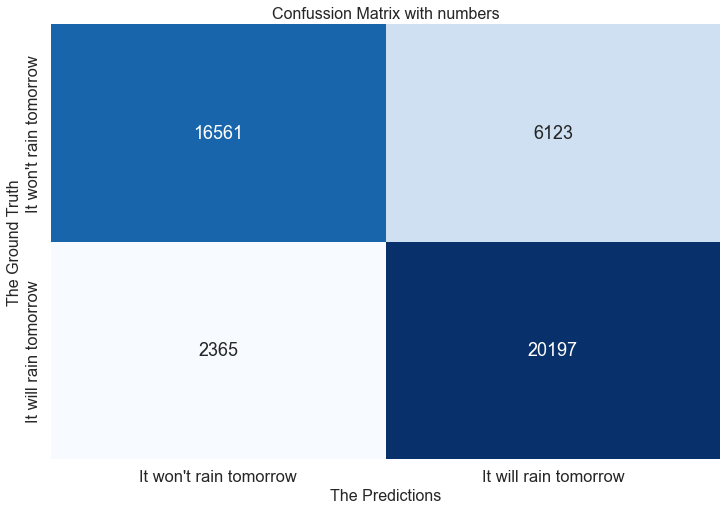

In [38]:
sns.set(font_scale = 1.5 , palette = "bright")
y_pred = tf.math.round(tf.squeeze(model.predict(test_set))).numpy()

sns.heatmap(data = cm , cmap = plt.cm.Blues , cbar = False , yticklabels=["It won't rain tomorrow" , "It will rain tomorrow"], 
            xticklabels=["It won't rain tomorrow" , "It will rain tomorrow"] , annot=True , fmt = ".5g")
plt.title("Confussion Matrix with numbers" , fontsize = 16)
plt.ylabel("The Ground Truth" , fontsize = 16)
plt.xlabel("The Predictions" , fontsize = 16)
plt.show()

# Roc Curve

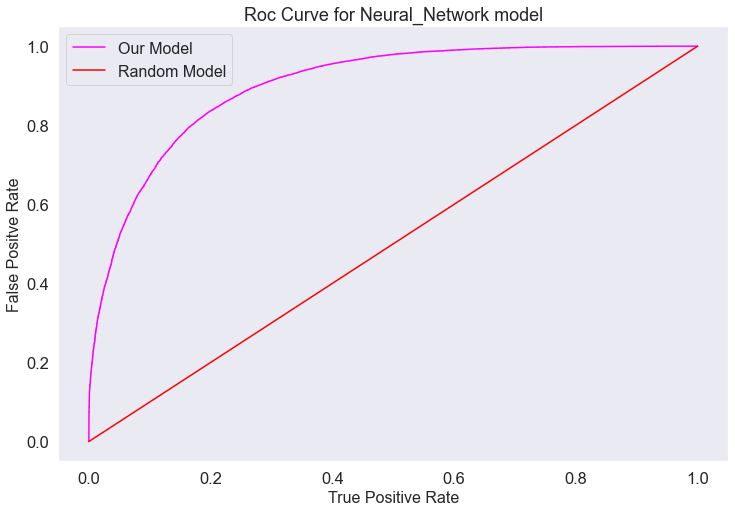

In [39]:
y_pred = tf.squeeze(model.predict(test_set)).numpy()

fpr , tpr , _ = roc_curve(y_true = y_test , y_score = y_pred)
plt.plot(fpr , tpr , label = "Our Model" , c = "magenta")
plt.plot([0,1] , [0,1] , label = "Random Model" , c = "red")
plt.title("Roc Curve for {} model".format(model.name))
plt.ylabel("False Positve Rate" , fontsize = 16)
plt.xlabel("True Positive Rate" , fontsize = 16)
plt.grid()
plt.legend(loc = "best" , fontsize = 16)
plt.show()